# Fashion-MNIST CNN and Transfer Learning for MNIST digit classification

##### A project carried out within the University of Buenos Aires, Faculty of Engineering, as part of the postgraduate program in Artificial Intelligence Specialization (CEIA).


In the initial section of this document, the focus will be on delineating an appropriate architecture for a CNN, tasked with addressing the Fashion-MNIST classification challenge. The primary objective is to find a suitable model with the best trade-off between training cost and accuracy.

Subsequently, in the second part of this document, a Transfer Learning strategy will be applied. This strategy aims to utilize the CNN trained in the initial section to address the MNIST digit classification problem, specifically identifying numbers greater or less than 4.5.

## Part 1

In this initial section, a CNN-based neural network architecture is developed for identifying the 10 classes within the Fashion MNIST dataset. The exploration encompasses six distinct CNN architectures, wherein various hyperparameters such as layer number, kernel number, and kernel size are systematically varied.

Among these six models, the optimal one will be chosen based on the accuracy. Furthermore, to potentially enhance the model's performance, dropout layers will be incorporated and assessed for their impact on the metrics.

In [1]:
# %pip install torchvision
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

In [2]:
# Download train data from open datasets.
train_data = datasets.FashionMNIST(root='data', train=True, download=True, transform=ToTensor(),)

# Download test data from open datsets.
test_data = datasets.FashionMNIST(root='data', train=False, download=True, transform=ToTensor(),)


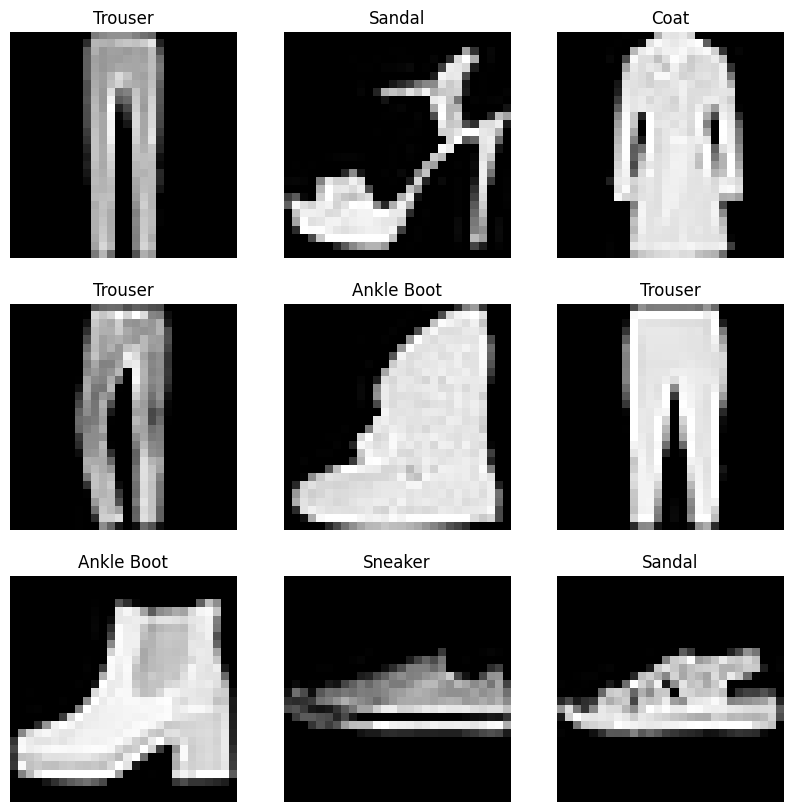

In [3]:
import matplotlib.pyplot as plt

labels_map={
    0: 'T-shirt',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle Boot',
}

figure = plt.figure(figsize = (10,10))
cols, rows = 3, 3

for i in range (1, cols*rows + 1):
    sample_idx = torch.randint(len(train_data), size = (1,)).item()
    image, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis('off')
    plt.imshow(image.squeeze(), cmap='gray')
plt.show()

Amount of training data available within the dataset.

In [4]:
train_data.data.size()

torch.Size([60000, 28, 28])

##### Methods shared by the models.

Dataset images size:

In [5]:
image.size()

torch.Size([1, 28, 28])

In [6]:
import numpy as np

Dataloader creation with train and test datasets.

In [7]:
# Dataloader creation
dataloader = {
    'train': torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True, pin_memory=True),
    'test': torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=False, pin_memory=True)
}

Convolution blocks that will be used within the models.

In [8]:
# Convolution block to use on the network

def conv_block(channels_in,
               channels_out,
               conv_kernel_size=7,
               conv_padding_size='same',
               conv_stride=1,
               pool_kernel_size=3,
               pool_stride=2,
               pool_padding_size=1):
    return torch.nn.Sequential(  # The Sequential module is responsible for making the forward step.
        torch.nn.Conv2d(channels_in, channels_out, conv_kernel_size, padding=conv_padding_size, stride=conv_stride), # conv
        torch.nn.Tanh(),                                                                                             # activation
        torch.nn.MaxPool2d(pool_kernel_size, stride=pool_stride, padding=pool_padding_size)                          # pooling
    )

In [9]:
def conv_block_relu(channels_in,
               channels_out,
               conv_kernel_size=7,
               conv_padding_size='same',
               conv_stride=1,
               pool_kernel_size=3,
               pool_stride=2,
               pool_padding_size=1,
               leaky_relu_slope=0.01):
    return torch.nn.Sequential(
        torch.nn.Conv2d(channels_in, channels_out, conv_kernel_size, padding=conv_padding_size, stride=conv_stride),
        #torch.nn.ReLU(),  # Changed to ReLU
        torch.nn.LeakyReLU(leaky_relu_slope),  # Changed to LeakyReLU
        torch.nn.MaxPool2d(pool_kernel_size, stride=pool_stride, padding=pool_padding_size)
    )

Setting the device for model training.

In [10]:
device = "cuda" if torch.cuda.is_available() else "cpu"

Fit code used in all models.

In [11]:
from tqdm import tqdm # <- to visualize the progress bar.


def fit(model, dataloader, epochs=15):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    criterion = torch.nn.CrossEntropyLoss()
    epoch_t_loss = []
    epoch_v_loss = []
    epoch_t_acc = []
    epoch_v_acc = []
    for epoch in range(1, epochs+1):
        model.train()
        train_loss, train_acc = [], []
        bar = tqdm(dataloader['train'])
        for batch in bar:
            X, y = batch
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            y_hat = model(X)
            loss = criterion(y_hat, y)
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
            ####
            acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y)
            train_acc.append(acc)
            bar.set_description(f"loss {np.mean(train_loss):.5f} acc {np.mean(train_acc):.5f}")

        epoch_t_loss.append(np.mean(train_loss))
        epoch_t_acc.append(np.mean(train_acc))

        bar = tqdm(dataloader['test'])
        val_loss, val_acc = [], []
        model.eval()
        with torch.no_grad():
            for batch in bar:
                X, y = batch
                X, y = X.to(device), y.to(device)
                y_hat = model(X)
                loss = criterion(y_hat, y)
                val_loss.append(loss.item())
                acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y)
                val_acc.append(acc)
                bar.set_description(f"val_loss {np.mean(val_loss):.5f} val_acc {np.mean(val_acc):.5f}")
        print(f"Epoch {epoch}/{epochs} loss {np.mean(train_loss):.5f} val_loss {np.mean(val_loss):.5f} acc {np.mean(train_acc):.5f} val_acc {np.mean(val_acc):.5f}")

        epoch_v_loss.append(np.mean(val_loss))
        epoch_v_acc.append(np.mean(val_acc))

    plt.figure()
    plt.plot(epoch_t_loss, 'r')
    plt.plot(epoch_v_loss, 'g')
    plt.title('loss')
    plt.legend(['train loss', 'val loss'])
    plt.grid()

    plt.figure()
    plt.plot(epoch_t_acc, 'r')
    plt.plot(epoch_v_acc, 'g')
    plt.title('acc')
    plt.legend(['train acc', 'val acc'])
    plt.grid()
    plt.show()

Number of epochs that will be used for all models.

In [12]:
n_epochs = 15

##### Model 1

Baseline model, used as the reference point.

In [13]:
# Model 1 creation

class CNN_model_1(torch.nn.Module):
  def __init__(self, n_channels=1, n_outputs=10):
    super().__init__()
    self.conv1 = conv_block(n_channels, 8)
    self.conv1_out = None
    self.conv2 = conv_block(8, 16)
    self.conv2_out = None
    self.conv3 = conv_block(16, 32)
    self.conv3_out = None
    self.fc = torch.nn.Linear(512, n_outputs) # Verify the dimension of the output to calculate the size of the Fully Connected !!
    
    print('NNET created')
    print('architecture:')
    print(self)

    i=0
    for layer in self.children():
        i=i+1
    print('Total number of CNN layers (conv+act+pooling) + fully connected added:', i)

    # Number of parameters to train
    pytorch_total_params = sum(p.numel() for p in self.parameters() if p.requires_grad)
    print('Total number of parameters to train: ', pytorch_total_params)

  def dim_validation(self, tam):
    # It is a "forward" function that prints the dimension of each step

    print("Dimensions validation")
    x = torch.randn(1, 1, int(tam), int(tam))
    print("Input size: ", x.shape)

    x = self.conv1(x)
    print("conv1 exit size: ", x.shape)
    x = self.conv2(x)
    print("conv2 exit size: ", x.shape)
    x = self.conv3(x)
    print("conv3 exit size: ", x.shape)

    x = x.view(x.shape[0], -1)
    print("Vectorized image size: ", x.shape)
    x = self.fc(x)
    print("fc exit size (# classes): ", x.shape)

  def forward(self, x):
    self.conv1_out = self.conv1(x)
    self.conv2_out = self.conv2(self.conv1_out)
    self.conv3_out = self.conv3(self.conv2_out)
    y = self.conv3_out.view(self.conv3_out.shape[0], -1)
    y = self.fc(y)
    
    return y

In [14]:
model_1 = CNN_model_1()

NNET created
architecture:
CNN_model_1(
  (conv1): Sequential(
    (0): Conv2d(1, 8, kernel_size=(7, 7), stride=(1, 1), padding=same)
    (1): Tanh()
    (2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(7, 7), stride=(1, 1), padding=same)
    (1): Tanh()
    (2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(7, 7), stride=(1, 1), padding=same)
    (1): Tanh()
    (2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=512, out_features=10, bias=True)
)
Total number of CNN layers (conv+act+pooling) + fully connected added: 4
Total number of parameters to train:  36938


Dimensions consistency analysis.

In [15]:
model_1.cpu()
model_1.dim_validation(image.size()[1])

Dimensions validation
Input size:  torch.Size([1, 1, 28, 28])
conv1 exit size:  torch.Size([1, 8, 14, 14])
conv2 exit size:  torch.Size([1, 16, 7, 7])
conv3 exit size:  torch.Size([1, 32, 4, 4])
Vectorized image size:  torch.Size([1, 512])
fc exit size (# classes):  torch.Size([1, 10])


val_loss 0.64667 val_acc 0.75776: 100%|██████████| 157/157 [00:00<00:00, 170.05it/s]


Epoch 1/15 loss 0.94831 val_loss 0.64667 acc 0.68737 val_acc 0.75776


val_loss 0.54883 val_acc 0.79857: 100%|██████████| 157/157 [00:00<00:00, 165.48it/s]


Epoch 2/15 loss 0.57025 val_loss 0.54883 acc 0.78925 val_acc 0.79857


val_loss 0.49064 val_acc 0.81867: 100%|██████████| 157/157 [00:00<00:00, 162.02it/s]


Epoch 3/15 loss 0.49424 val_loss 0.49064 acc 0.81991 val_acc 0.81867


val_loss 0.44875 val_acc 0.83758: 100%|██████████| 157/157 [00:01<00:00, 153.78it/s]


Epoch 4/15 loss 0.44387 val_loss 0.44875 acc 0.83849 val_acc 0.83758


val_loss 0.42122 val_acc 0.84922: 100%|██████████| 157/157 [00:01<00:00, 149.92it/s]


Epoch 5/15 loss 0.40643 val_loss 0.42122 acc 0.85280 val_acc 0.84922


val_loss 0.39700 val_acc 0.85788: 100%|██████████| 157/157 [00:00<00:00, 158.01it/s]


Epoch 6/15 loss 0.38102 val_loss 0.39700 acc 0.86072 val_acc 0.85788


val_loss 0.37948 val_acc 0.86316: 100%|██████████| 157/157 [00:00<00:00, 168.18it/s]


Epoch 7/15 loss 0.36070 val_loss 0.37948 acc 0.87030 val_acc 0.86316


val_loss 0.36733 val_acc 0.86773: 100%|██████████| 157/157 [00:01<00:00, 147.55it/s]


Epoch 8/15 loss 0.34545 val_loss 0.36733 acc 0.87385 val_acc 0.86773


val_loss 0.35879 val_acc 0.86992: 100%|██████████| 157/157 [00:00<00:00, 165.46it/s]


Epoch 9/15 loss 0.33340 val_loss 0.35879 acc 0.87866 val_acc 0.86992


val_loss 0.34568 val_acc 0.87560: 100%|██████████| 157/157 [00:00<00:00, 166.59it/s]


Epoch 10/15 loss 0.32240 val_loss 0.34568 acc 0.88183 val_acc 0.87560


val_loss 0.33685 val_acc 0.87888: 100%|██████████| 157/157 [00:00<00:00, 168.39it/s]


Epoch 11/15 loss 0.31348 val_loss 0.33685 acc 0.88536 val_acc 0.87888


val_loss 0.33070 val_acc 0.88187: 100%|██████████| 157/157 [00:01<00:00, 143.29it/s]


Epoch 12/15 loss 0.30438 val_loss 0.33070 acc 0.88941 val_acc 0.88187


val_loss 0.32418 val_acc 0.88436: 100%|██████████| 157/157 [00:01<00:00, 149.26it/s]


Epoch 13/15 loss 0.29703 val_loss 0.32418 acc 0.89169 val_acc 0.88436


val_loss 0.32166 val_acc 0.88326: 100%|██████████| 157/157 [00:01<00:00, 156.06it/s]


Epoch 14/15 loss 0.28956 val_loss 0.32166 acc 0.89427 val_acc 0.88326


val_loss 0.32229 val_acc 0.88067: 100%|██████████| 157/157 [00:01<00:00, 153.51it/s]


Epoch 15/15 loss 0.28360 val_loss 0.32229 acc 0.89684 val_acc 0.88067


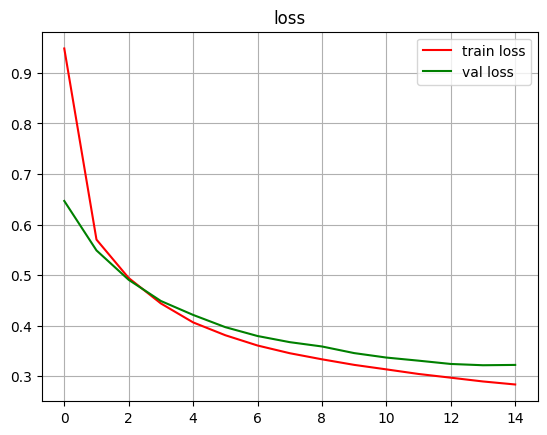

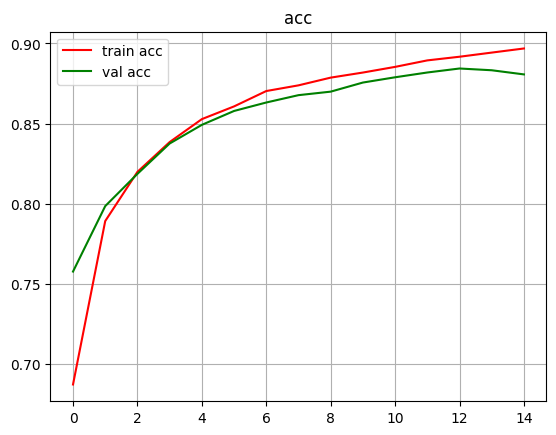

In [16]:
# Train the model
fit(model_1, dataloader, epochs=n_epochs)

In [17]:
# Save the model
torch.save(model_1.state_dict(), 'content/model_1.pth')

##### Model 2

Taking Model 1 as the baseline, doubling the number of output channels in each layer (conv1, conv2, and conv3). Additionally, two more convolutional layers (conv4 and conv5) are added.

In [18]:
# Model 2 creation

class CNN_model_2(torch.nn.Module):
  def __init__(self, n_channels=1, n_outputs=10):
    super().__init__()
    self.conv1 = conv_block(n_channels, 16)
    self.conv1_out = None
    self.conv2 = conv_block(16, 32)
    self.conv2_out = None
    self.conv3 = conv_block(32, 64)
    self.conv3_out = None
    self.conv4 = conv_block(64, 32)
    self.conv4_out = None
    self.conv5 = conv_block(32, 16)
    self.conv5_out = None
    self.fc = torch.nn.Linear(16, n_outputs) # Verify the dimension of the output to calculate the size of the Fully Connected !!
    

    print('NNET created')
    print('architecture:')

    print(self)

    i=0
    for layer in self.children():
        i=i+1
    print('Total number of CNN layers (conv+act+pooling) + fully connected added:', i)

    # Number of parameters to train
    pytorch_total_params = sum(p.numel() for p in self.parameters() if p.requires_grad)
    print('Total number of parameters to train: ', pytorch_total_params)

  def dim_validation(self, tam):
    # It is a "forward" function that prints the dimension of each step

    print("Dimensions validation")
    x = torch.randn(1, 1, int(tam), int(tam))
    print("Input size: ", x.shape)

    x = self.conv1(x)
    print("conv1 exit size: ", x.shape)
    x = self.conv2(x)
    print("conv2 exit size: ", x.shape)
    x = self.conv3(x)
    print("conv3 exit size: ", x.shape)
    x = self.conv4(x)
    print("conv4 exit size: ", x.shape)
    x = self.conv5(x)
    print("conv5 exit size: ", x.shape)

    x = x.view(x.shape[0], -1)
    print("Vectorized image size: ", x.shape)
    x = self.fc(x)
    print("fc exit size (# classes): ", x.shape)

  def forward(self, x):
    self.conv1_out = self.conv1(x)
    self.conv2_out = self.conv2(self.conv1_out)
    self.conv3_out = self.conv3(self.conv2_out)
    self.conv4_out = self.conv4(self.conv3_out)
    self.conv5_out = self.conv5(self.conv4_out)
    y = self.conv5_out.view(self.conv5_out.shape[0], -1)
    y = self.fc(y)
    
    return y

In [19]:
model_2 = CNN_model_2()

NNET created
architecture:
CNN_model_2(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(7, 7), stride=(1, 1), padding=same)
    (1): Tanh()
    (2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(7, 7), stride=(1, 1), padding=same)
    (1): Tanh()
    (2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(7, 7), stride=(1, 1), padding=same)
    (1): Tanh()
    (2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(64, 32, kernel_size=(7, 7), stride=(1, 1), padding=same)
    (1): Tanh()
    (2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (conv5): Sequential(
    (0): Conv2d(32, 16, kernel_size=(7, 7), stride=(1, 1), padding=same)
    (1): Tanh()
    (2): MaxPool2d(kernel_size=3, stride=2, paddi

Dimensions consistency analysis.

In [20]:
model_2.cpu()
model_2.dim_validation(image.size()[1])

Dimensions validation
Input size:  torch.Size([1, 1, 28, 28])
conv1 exit size:  torch.Size([1, 16, 14, 14])
conv2 exit size:  torch.Size([1, 32, 7, 7])
conv3 exit size:  torch.Size([1, 64, 4, 4])
conv4 exit size:  torch.Size([1, 32, 2, 2])
conv5 exit size:  torch.Size([1, 16, 1, 1])
Vectorized image size:  torch.Size([1, 16])
fc exit size (# classes):  torch.Size([1, 10])


val_loss 1.01462 val_acc 0.70303: 100%|██████████| 157/157 [00:01<00:00, 143.27it/s]


Epoch 1/15 loss 1.39666 val_loss 1.01462 acc 0.57809 val_acc 0.70303


val_loss 0.71726 val_acc 0.80334: 100%|██████████| 157/157 [00:01<00:00, 152.85it/s]


Epoch 2/15 loss 0.84613 val_loss 0.71726 acc 0.76756 val_acc 0.80334


val_loss 0.56909 val_acc 0.83081: 100%|██████████| 157/157 [00:01<00:00, 129.49it/s]


Epoch 3/15 loss 0.62404 val_loss 0.56909 acc 0.82644 val_acc 0.83081


val_loss 0.48250 val_acc 0.84713: 100%|██████████| 157/157 [00:01<00:00, 145.69it/s]


Epoch 4/15 loss 0.51043 val_loss 0.48250 acc 0.84608 val_acc 0.84713


val_loss 0.44093 val_acc 0.85569: 100%|██████████| 157/157 [00:01<00:00, 136.90it/s]


Epoch 5/15 loss 0.44639 val_loss 0.44093 acc 0.85909 val_acc 0.85569


val_loss 0.40749 val_acc 0.86236: 100%|██████████| 157/157 [00:01<00:00, 147.08it/s]


Epoch 6/15 loss 0.39966 val_loss 0.40749 acc 0.86997 val_acc 0.86236


val_loss 0.37205 val_acc 0.87470: 100%|██████████| 157/157 [00:01<00:00, 144.83it/s]


Epoch 7/15 loss 0.36421 val_loss 0.37205 acc 0.88005 val_acc 0.87470


val_loss 0.35173 val_acc 0.88077: 100%|██████████| 157/157 [00:01<00:00, 131.63it/s]


Epoch 8/15 loss 0.33556 val_loss 0.35173 acc 0.88794 val_acc 0.88077


val_loss 0.33437 val_acc 0.88625: 100%|██████████| 157/157 [00:01<00:00, 151.52it/s]


Epoch 9/15 loss 0.31321 val_loss 0.33437 acc 0.89531 val_acc 0.88625


val_loss 0.31775 val_acc 0.89242: 100%|██████████| 157/157 [00:01<00:00, 153.15it/s]


Epoch 10/15 loss 0.29519 val_loss 0.31775 acc 0.89914 val_acc 0.89242


val_loss 0.31184 val_acc 0.89301: 100%|██████████| 157/157 [00:01<00:00, 152.86it/s]


Epoch 11/15 loss 0.28247 val_loss 0.31184 acc 0.90330 val_acc 0.89301


val_loss 0.30736 val_acc 0.89461: 100%|██████████| 157/157 [00:01<00:00, 140.91it/s]


Epoch 12/15 loss 0.26863 val_loss 0.30736 acc 0.90703 val_acc 0.89461


val_loss 0.29875 val_acc 0.89709: 100%|██████████| 157/157 [00:01<00:00, 146.15it/s]


Epoch 13/15 loss 0.25989 val_loss 0.29875 acc 0.90988 val_acc 0.89709


val_loss 0.30025 val_acc 0.89421: 100%|██████████| 157/157 [00:01<00:00, 152.63it/s]


Epoch 14/15 loss 0.24981 val_loss 0.30025 acc 0.91316 val_acc 0.89421


val_loss 0.28894 val_acc 0.89759: 100%|██████████| 157/157 [00:01<00:00, 152.67it/s]


Epoch 15/15 loss 0.24218 val_loss 0.28894 acc 0.91618 val_acc 0.89759


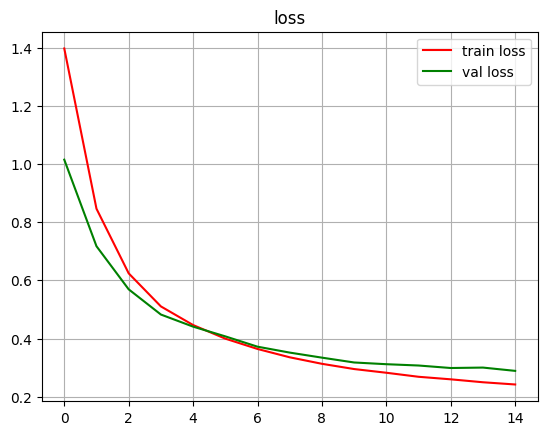

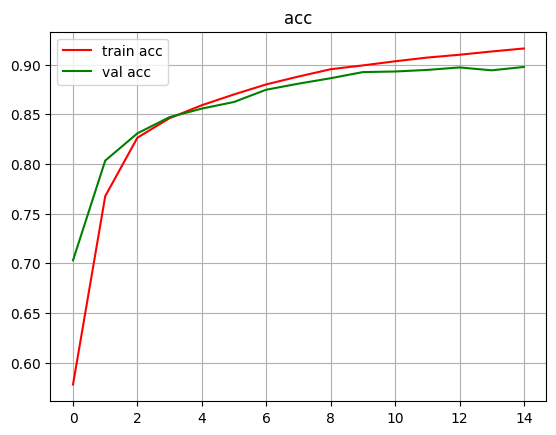

In [21]:
# Train the model
fit(model_2, dataloader, epochs=n_epochs)

In [22]:
# Save the model
torch.save(model_2.state_dict(), 'content/model_2.pth')

No significant improvements are observed. However, the number of parameters to train has increased substantially with model_2. Therefore, model_1 is once again taken as the baseline.

##### Model 3

Building upon model 1, adding one more convolutional layer (conv4).

In [23]:
# Model 3 creation

class CNN_model_3(torch.nn.Module):
  def __init__(self, n_channels=1, n_outputs=10):
    super().__init__()
    self.conv1 = conv_block(n_channels, 8)
    self.conv1_out = None
    self.conv2 = conv_block(8, 16)
    self.conv2_out = None
    self.conv3 = conv_block(16, 32)
    self.conv3_out = None
    self.conv4 = conv_block(32, 16)
    self.conv4_out = None
    self.fc = torch.nn.Linear(64, n_outputs) # Verify the dimension of the output to calculate the size of the Fully Connected !!
    
    print('NNET created')

    print('NNET created')
    print('architecture:')
    print(self)

    i=0
    for layer in self.children():
        i=i+1
    print('Total number of CNN layers (conv+act+pooling) + fully connected added:', i)

    # Number of parameters to train
    pytorch_total_params = sum(p.numel() for p in self.parameters() if p.requires_grad)
    print('Total number of parameters to train: ', pytorch_total_params)

  def dim_validation(self, tam):
    # It is a "forward" function that prints the dimension of each step

    print("Dimensions validation")
    x = torch.randn(1, 1, int(tam), int(tam))
    print("Input size: ", x.shape)

    x = self.conv1(x)
    print("conv1 exit size: ", x.shape)
    x = self.conv2(x)
    print("conv2 exit size: ", x.shape)
    x = self.conv3(x)
    print("conv3 exit size: ", x.shape)
    x = self.conv4(x)
    print("conv4 exit size: ", x.shape)

    x = x.view(x.shape[0], -1)
    print("Vectorized image size: ", x.shape)
    x = self.fc(x)
    print("fc exit size (# classes): ", x.shape)

  def forward(self, x):
    self.conv1_out = self.conv1(x)
    self.conv2_out = self.conv2(self.conv1_out)
    self.conv3_out = self.conv3(self.conv2_out)
    self.conv4_out = self.conv4(self.conv3_out)
    y = self.conv4_out.view(self.conv4_out.shape[0], -1)
    y = self.fc(y)
    
    return y

In [24]:
model_3 = CNN_model_3()

NNET created
NNET created
architecture:
CNN_model_3(
  (conv1): Sequential(
    (0): Conv2d(1, 8, kernel_size=(7, 7), stride=(1, 1), padding=same)
    (1): Tanh()
    (2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(7, 7), stride=(1, 1), padding=same)
    (1): Tanh()
    (2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(7, 7), stride=(1, 1), padding=same)
    (1): Tanh()
    (2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(32, 16, kernel_size=(7, 7), stride=(1, 1), padding=same)
    (1): Tanh()
    (2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=64, out_features=10, bias=True)
)
Total number of CNN layers (conv+act+pooling) + fully connected added: 5
Total number of 

In [25]:
model_3.cpu()
model_3.dim_validation(image.size()[1])

Dimensions validation
Input size:  torch.Size([1, 1, 28, 28])
conv1 exit size:  torch.Size([1, 8, 14, 14])
conv2 exit size:  torch.Size([1, 16, 7, 7])
conv3 exit size:  torch.Size([1, 32, 4, 4])
conv4 exit size:  torch.Size([1, 16, 2, 2])
Vectorized image size:  torch.Size([1, 64])
fc exit size (# classes):  torch.Size([1, 10])


val_loss 0.70357 val_acc 0.75060: 100%|██████████| 157/157 [00:01<00:00, 151.07it/s]


Epoch 1/15 loss 1.09693 val_loss 0.70357 acc 0.63748 val_acc 0.75060


val_loss 0.57800 val_acc 0.78852: 100%|██████████| 157/157 [00:01<00:00, 155.88it/s]


Epoch 2/15 loss 0.61609 val_loss 0.57800 acc 0.77609 val_acc 0.78852


val_loss 0.51463 val_acc 0.80941: 100%|██████████| 157/157 [00:01<00:00, 154.06it/s]


Epoch 3/15 loss 0.52656 val_loss 0.51463 acc 0.80657 val_acc 0.80941


val_loss 0.47054 val_acc 0.83051: 100%|██████████| 157/157 [00:01<00:00, 134.67it/s]


Epoch 4/15 loss 0.47248 val_loss 0.47054 acc 0.82827 val_acc 0.83051


val_loss 0.43984 val_acc 0.84126: 100%|██████████| 157/157 [00:01<00:00, 143.72it/s]


Epoch 5/15 loss 0.43334 val_loss 0.43984 acc 0.84162 val_acc 0.84126


val_loss 0.41872 val_acc 0.84415: 100%|██████████| 157/157 [00:01<00:00, 151.12it/s]


Epoch 6/15 loss 0.40591 val_loss 0.41872 acc 0.85126 val_acc 0.84415


val_loss 0.39680 val_acc 0.85440: 100%|██████████| 157/157 [00:01<00:00, 149.22it/s]


Epoch 7/15 loss 0.38430 val_loss 0.39680 acc 0.85833 val_acc 0.85440


val_loss 0.38617 val_acc 0.85778: 100%|██████████| 157/157 [00:01<00:00, 130.64it/s]


Epoch 8/15 loss 0.36577 val_loss 0.38617 acc 0.86564 val_acc 0.85778


val_loss 0.36655 val_acc 0.86405: 100%|██████████| 157/157 [00:01<00:00, 155.93it/s]


Epoch 9/15 loss 0.34947 val_loss 0.36655 acc 0.87142 val_acc 0.86405


val_loss 0.35651 val_acc 0.86674: 100%|██████████| 157/157 [00:01<00:00, 154.46it/s]


Epoch 10/15 loss 0.33523 val_loss 0.35651 acc 0.87720 val_acc 0.86674


val_loss 0.34289 val_acc 0.87112: 100%|██████████| 157/157 [00:01<00:00, 154.74it/s]


Epoch 11/15 loss 0.32409 val_loss 0.34289 acc 0.88148 val_acc 0.87112


val_loss 0.34189 val_acc 0.87162: 100%|██████████| 157/157 [00:01<00:00, 141.54it/s]


Epoch 12/15 loss 0.31308 val_loss 0.34189 acc 0.88514 val_acc 0.87162


val_loss 0.33435 val_acc 0.87600: 100%|██████████| 157/157 [00:01<00:00, 153.28it/s]


Epoch 13/15 loss 0.30532 val_loss 0.33435 acc 0.88853 val_acc 0.87600


val_loss 0.32243 val_acc 0.87878: 100%|██████████| 157/157 [00:01<00:00, 145.51it/s]


Epoch 14/15 loss 0.29646 val_loss 0.32243 acc 0.89046 val_acc 0.87878


val_loss 0.31493 val_acc 0.88366: 100%|██████████| 157/157 [00:01<00:00, 137.98it/s]


Epoch 15/15 loss 0.28993 val_loss 0.31493 acc 0.89344 val_acc 0.88366


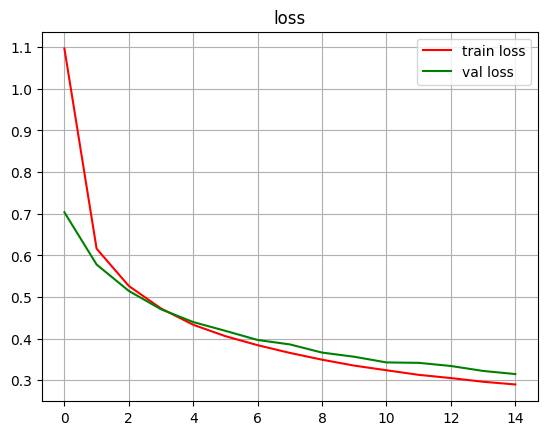

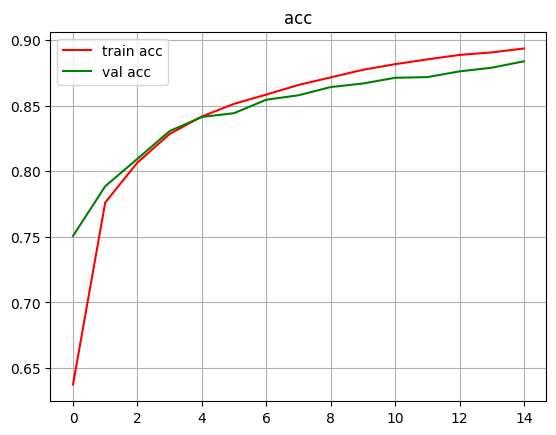

In [26]:
# Train the model
fit(model_3, dataloader, epochs=n_epochs)

In [27]:
# Save the model
torch.save(model_3.state_dict(), 'content/model_3.pth')

Compared to model 1, this model achieved nearly the same accuracy but with a slightly higher number of parameters to train (from 36,938 to 57,562).

##### Model 4

We use model 1 as the baseline, and change the activation function to LeakyReLU.

In [28]:
# Model 4 creation

class CNN_model_4(torch.nn.Module):
  def __init__(self, n_channels=1, n_outputs=10):
    super().__init__()
    self.conv1 = conv_block_relu(n_channels, 8, leaky_relu_slope=0.001)
    self.conv1_out = None
    self.conv2 = conv_block_relu(8, 16, leaky_relu_slope=0.001)
    self.conv2_out = None
    self.conv3 = conv_block_relu(16, 32, leaky_relu_slope=0.001)
    self.conv3_out = None
    self.fc = torch.nn.Linear(512, n_outputs) # Verify the dimension of the output to calculate the size of the Fully Connected !!
    
    print('NNET created')

    print('NNET created')
    print('architecture:')
    print(self)

    i=0
    for layer in self.children():
        i=i+1
    print('Total number of CNN layers (conv+act+pooling) + fully connected added:', i)

    # Number of parameters to train
    pytorch_total_params = sum(p.numel() for p in self.parameters() if p.requires_grad)
    print('Total number of parameters to train: ', pytorch_total_params)

  def dim_validation(self, tam):
    # It is a "forward" function that prints the dimension of each step

    print("Dimensions validation")
    x = torch.randn(1, 1, int(tam), int(tam))
    print("Input size: ", x.shape)


    x = self.conv1(x)
    print("conv1 exit size: ", x.shape)
    x = self.conv2(x)
    print("conv2 exit size: ", x.shape)
    x = self.conv3(x)
    print("conv3 exit size: ", x.shape)

    x = x.view(x.shape[0], -1)
    print("Vectorized image size: ", x.shape)
    x = self.fc(x)
    print("fc exit size (# classes): ", x.shape)

  def forward(self, x):
    self.conv1_out = self.conv1(x)
    self.conv2_out = self.conv2(self.conv1_out)
    self.conv3_out = self.conv3(self.conv2_out)
    y = self.conv3_out.view(self.conv3_out.shape[0], -1)
    y = self.fc(y)
    
    return y

In [29]:
model_4 = CNN_model_4()

NNET created
NNET created
architecture:
CNN_model_4(
  (conv1): Sequential(
    (0): Conv2d(1, 8, kernel_size=(7, 7), stride=(1, 1), padding=same)
    (1): LeakyReLU(negative_slope=0.001)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(7, 7), stride=(1, 1), padding=same)
    (1): LeakyReLU(negative_slope=0.001)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(7, 7), stride=(1, 1), padding=same)
    (1): LeakyReLU(negative_slope=0.001)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=512, out_features=10, bias=True)
)
Total number of CNN layers (conv+act+pooling) + fully connected added: 4
Total number of parameters to train:  36938


In [30]:
model_4.cpu()
model_4.dim_validation(image.size()[1])

Dimensions validation
Input size:  torch.Size([1, 1, 28, 28])
conv1 exit size:  torch.Size([1, 8, 14, 14])
conv2 exit size:  torch.Size([1, 16, 7, 7])
conv3 exit size:  torch.Size([1, 32, 4, 4])
Vectorized image size:  torch.Size([1, 512])
fc exit size (# classes):  torch.Size([1, 10])


val_loss 0.70272 val_acc 0.73706: 100%|██████████| 157/157 [00:01<00:00, 155.90it/s]


Epoch 1/15 loss 0.94190 val_loss 0.70272 acc 0.67522 val_acc 0.73706


val_loss 0.61640 val_acc 0.77369: 100%|██████████| 157/157 [00:00<00:00, 160.04it/s]


Epoch 2/15 loss 0.63425 val_loss 0.61640 acc 0.76739 val_acc 0.77369


val_loss 0.56434 val_acc 0.79429: 100%|██████████| 157/157 [00:00<00:00, 157.15it/s]


Epoch 3/15 loss 0.57201 val_loss 0.56434 acc 0.79028 val_acc 0.79429


val_loss 0.54130 val_acc 0.80732: 100%|██████████| 157/157 [00:01<00:00, 155.38it/s]


Epoch 4/15 loss 0.52370 val_loss 0.54130 acc 0.80995 val_acc 0.80732


val_loss 0.50998 val_acc 0.81608: 100%|██████████| 157/157 [00:01<00:00, 155.51it/s]


Epoch 5/15 loss 0.49197 val_loss 0.50998 acc 0.82286 val_acc 0.81608


val_loss 0.48346 val_acc 0.82892: 100%|██████████| 157/157 [00:01<00:00, 152.13it/s]


Epoch 6/15 loss 0.46373 val_loss 0.48346 acc 0.83422 val_acc 0.82892


val_loss 0.46311 val_acc 0.83808: 100%|██████████| 157/157 [00:01<00:00, 143.44it/s]


Epoch 7/15 loss 0.43996 val_loss 0.46311 acc 0.84253 val_acc 0.83808


val_loss 0.44228 val_acc 0.84206: 100%|██████████| 157/157 [00:01<00:00, 138.81it/s]


Epoch 8/15 loss 0.42098 val_loss 0.44228 acc 0.84865 val_acc 0.84206


val_loss 0.41794 val_acc 0.84962: 100%|██████████| 157/157 [00:01<00:00, 144.82it/s]


Epoch 9/15 loss 0.40598 val_loss 0.41794 acc 0.85536 val_acc 0.84962


val_loss 0.40666 val_acc 0.85430: 100%|██████████| 157/157 [00:01<00:00, 146.85it/s]


Epoch 10/15 loss 0.39277 val_loss 0.40666 acc 0.85991 val_acc 0.85430


val_loss 0.40096 val_acc 0.85878: 100%|██████████| 157/157 [00:01<00:00, 149.87it/s]


Epoch 11/15 loss 0.38150 val_loss 0.40096 acc 0.86382 val_acc 0.85878


val_loss 0.40200 val_acc 0.85898: 100%|██████████| 157/157 [00:01<00:00, 139.89it/s]


Epoch 12/15 loss 0.37308 val_loss 0.40200 acc 0.86640 val_acc 0.85898


val_loss 0.38284 val_acc 0.86584: 100%|██████████| 157/157 [00:01<00:00, 130.24it/s]


Epoch 13/15 loss 0.36262 val_loss 0.38284 acc 0.87025 val_acc 0.86584


val_loss 0.37752 val_acc 0.86714: 100%|██████████| 157/157 [00:01<00:00, 143.22it/s]


Epoch 14/15 loss 0.35461 val_loss 0.37752 acc 0.87278 val_acc 0.86714


val_loss 0.37524 val_acc 0.86574: 100%|██████████| 157/157 [00:01<00:00, 151.26it/s]


Epoch 15/15 loss 0.34859 val_loss 0.37524 acc 0.87572 val_acc 0.86574


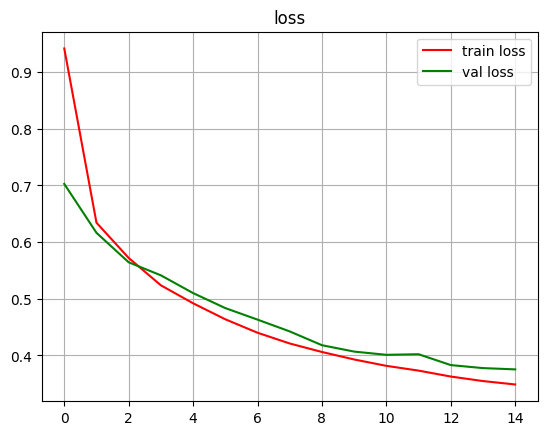

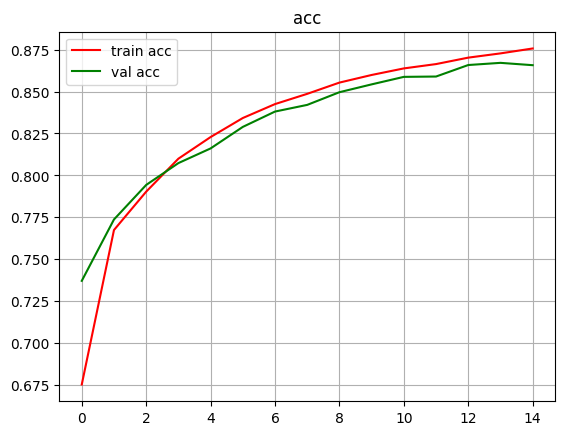

In [31]:
# Train the model
fit(model_4, dataloader, epochs=n_epochs)

In [32]:
# Save the model
torch.save(model_4.state_dict(), 'content/model_4.pth')

No significant changes are observed when using LeakyReLU.

##### Model 5

A single convolutional layer is employed, and the size of both the convolutional and pooling kernels is changed. The goal is to obtain a model that does not exceed 200,000 parameters to train.

In [33]:
# Model 5 creation

class CNN_model_5(torch.nn.Module):
  def __init__(self, n_channels=1, n_outputs=10):
    super().__init__()

    conv_kernel_size=(9, 9)
    conv_stride_size=(1, 1)
    conv_padding_size=(0, 0)

    pool_kernel_size=(2, 2)
    pool_stride_size=(2, 2)

    self.conv1 = conv_block(n_channels, 64,
                            conv_kernel_size,
                            conv_padding_size=conv_padding_size,
                            conv_stride=conv_stride_size,
                            pool_kernel_size=pool_kernel_size,
                            pool_stride=pool_stride_size,
                            pool_padding_size=1)
    self.conv1_out = None

    self.fc = torch.nn.Linear(7744, n_outputs) # Verify the dimension of the output to calculate the size of the Fully Connected !!
    # self.sm = torch.nn.Softmax(dim=1)
    print('NNET created')

    print('NNET created')
    print('architecture:')
    print(self)

    i=0
    for layer in self.children():
        i=i+1
    print('Total number of CNN layers (conv+act+pooling) + fully connected added:', i)

    # Number of parameters to train
    pytorch_total_params = sum(p.numel() for p in self.parameters() if p.requires_grad)
    print('Total number of parameters to train: ', pytorch_total_params)

  def dim_validation(self, tam):
    # It is a "forward" function that prints the dimension of each step

    print("Dimensions validation")
    x = torch.randn(1, 1, int(tam), int(tam))
    print("Input size: ", x.shape)

    x = self.conv1(x)
    print("conv1 exit size: ", x.shape)

    x = x.view(x.shape[0], -1)
    print("Vectorized image size: ", x.shape)
    x = self.fc(x)
    print("fc exit size (# classes): ", x.shape)

  def forward(self, x):
    self.conv1_out = self.conv1(x)
    y = self.conv1_out.view(self.conv1_out.shape[0], -1)
    y = self.fc(y)
    
    return y

In [34]:
model_5 = CNN_model_5()

NNET created
NNET created
architecture:
CNN_model_5(
  (conv1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(9, 9), stride=(1, 1))
    (1): Tanh()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=1, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=7744, out_features=10, bias=True)
)
Total number of CNN layers (conv+act+pooling) + fully connected added: 2
Total number of parameters to train:  82698


In [35]:
model_5.cpu()
model_5.dim_validation(image.size()[1])

Dimensions validation
Input size:  torch.Size([1, 1, 28, 28])
conv1 exit size:  torch.Size([1, 64, 11, 11])
Vectorized image size:  torch.Size([1, 7744])
fc exit size (# classes):  torch.Size([1, 10])


val_loss 0.51129 val_acc 0.81389: 100%|██████████| 157/157 [00:00<00:00, 164.67it/s]


Epoch 1/20 loss 0.65665 val_loss 0.51129 acc 0.78107 val_acc 0.81389


val_loss 0.46038 val_acc 0.83629: 100%|██████████| 157/157 [00:01<00:00, 127.32it/s]


Epoch 2/20 loss 0.46040 val_loss 0.46038 acc 0.83975 val_acc 0.83629


val_loss 0.43531 val_acc 0.84365: 100%|██████████| 157/157 [00:01<00:00, 136.32it/s]


Epoch 3/20 loss 0.42172 val_loss 0.43531 acc 0.85228 val_acc 0.84365


val_loss 0.42982 val_acc 0.84514: 100%|██████████| 157/157 [00:01<00:00, 147.63it/s]


Epoch 4/20 loss 0.39822 val_loss 0.42982 acc 0.86121 val_acc 0.84514


val_loss 0.39851 val_acc 0.85788: 100%|██████████| 157/157 [00:01<00:00, 155.75it/s]


Epoch 5/20 loss 0.38261 val_loss 0.39851 acc 0.86497 val_acc 0.85788


val_loss 0.39572 val_acc 0.86047: 100%|██████████| 157/157 [00:00<00:00, 162.04it/s]


Epoch 6/20 loss 0.36742 val_loss 0.39572 acc 0.87175 val_acc 0.86047


val_loss 0.37606 val_acc 0.86714: 100%|██████████| 157/157 [00:01<00:00, 148.32it/s]


Epoch 7/20 loss 0.35529 val_loss 0.37606 acc 0.87497 val_acc 0.86714


val_loss 0.37337 val_acc 0.86783: 100%|██████████| 157/157 [00:01<00:00, 156.23it/s]


Epoch 8/20 loss 0.34603 val_loss 0.37337 acc 0.87903 val_acc 0.86783


val_loss 0.35861 val_acc 0.87301: 100%|██████████| 157/157 [00:00<00:00, 160.42it/s]


Epoch 9/20 loss 0.33696 val_loss 0.35861 acc 0.88115 val_acc 0.87301


val_loss 0.35689 val_acc 0.87440: 100%|██████████| 157/157 [00:00<00:00, 164.16it/s]


Epoch 10/20 loss 0.32856 val_loss 0.35689 acc 0.88368 val_acc 0.87440


val_loss 0.35350 val_acc 0.87351: 100%|██████████| 157/157 [00:00<00:00, 157.54it/s]


Epoch 11/20 loss 0.32045 val_loss 0.35350 acc 0.88739 val_acc 0.87351


val_loss 0.34422 val_acc 0.87769: 100%|██████████| 157/157 [00:00<00:00, 160.08it/s]


Epoch 12/20 loss 0.31381 val_loss 0.34422 acc 0.88931 val_acc 0.87769


val_loss 0.33605 val_acc 0.87968: 100%|██████████| 157/157 [00:00<00:00, 160.57it/s]


Epoch 13/20 loss 0.30872 val_loss 0.33605 acc 0.89147 val_acc 0.87968


val_loss 0.33456 val_acc 0.88117: 100%|██████████| 157/157 [00:00<00:00, 159.59it/s]


Epoch 14/20 loss 0.30110 val_loss 0.33456 acc 0.89359 val_acc 0.88117


val_loss 0.34102 val_acc 0.87719: 100%|██████████| 157/157 [00:00<00:00, 160.48it/s]


Epoch 15/20 loss 0.29634 val_loss 0.34102 acc 0.89461 val_acc 0.87719


val_loss 0.33550 val_acc 0.88027: 100%|██████████| 157/157 [00:01<00:00, 128.97it/s]


Epoch 16/20 loss 0.29100 val_loss 0.33550 acc 0.89661 val_acc 0.88027


val_loss 0.32223 val_acc 0.88445: 100%|██████████| 157/157 [00:01<00:00, 138.22it/s]


Epoch 17/20 loss 0.28589 val_loss 0.32223 acc 0.89915 val_acc 0.88445


val_loss 0.31763 val_acc 0.88515: 100%|██████████| 157/157 [00:01<00:00, 149.55it/s]


Epoch 18/20 loss 0.28212 val_loss 0.31763 acc 0.89955 val_acc 0.88515


val_loss 0.31519 val_acc 0.88485: 100%|██████████| 157/157 [00:01<00:00, 120.01it/s]


Epoch 19/20 loss 0.27741 val_loss 0.31519 acc 0.90207 val_acc 0.88485


val_loss 0.32523 val_acc 0.88426: 100%|██████████| 157/157 [00:01<00:00, 149.87it/s]


Epoch 20/20 loss 0.27402 val_loss 0.32523 acc 0.90234 val_acc 0.88426


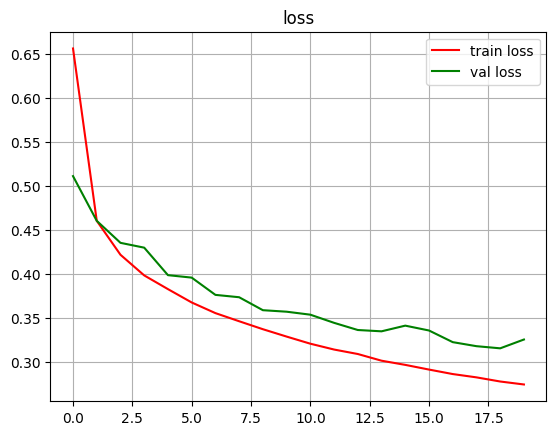

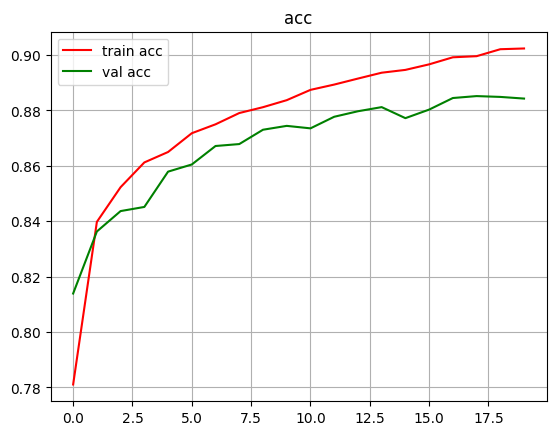

In [36]:
# Train the model
fit(model_5, dataloader, epochs=20)

In [37]:
# Save the model
torch.save(model_5.state_dict(), 'content/model_5.pth')

Model 5 has shown the best results so far in terms of the number of parameters to train. However, there seems to be overfitting when looking at the training and validation metrics.

##### Model 6

In this model, the number of channels is doubled for each convolutional layer, a fourth convolutional layer is added, and the kernel values for convolution and pooling are modified.

In [38]:
# Model 6 creation

class CNN_model_6(torch.nn.Module):
  def __init__(self, n_channels=1, n_outputs=10):
    super().__init__()

    conv_kernel_size=(5, 5)
    conv_stride_size=(1, 1)
    conv_padding_size='same'

    pool_kernel_size=(2, 2)
    pool_stride_size=(2, 2)

    self.conv1 = conv_block(n_channels, 16,
                            conv_kernel_size,
                            conv_padding_size=conv_padding_size,
                            conv_stride=conv_stride_size,
                            pool_kernel_size=pool_kernel_size,
                            pool_stride=pool_stride_size,
                            pool_padding_size=1)
    self.conv1_out = None
    self.conv2 = conv_block(16, 32,
                        conv_kernel_size,
                        conv_padding_size=conv_padding_size,
                        conv_stride=conv_stride_size,
                        pool_kernel_size=pool_kernel_size,
                        pool_stride=pool_stride_size,
                        pool_padding_size=1)
    self.conv2_out = None
    self.conv3 = conv_block(32, 64,
                    conv_kernel_size,
                    conv_padding_size=conv_padding_size,
                    conv_stride=conv_stride_size,
                    pool_kernel_size=pool_kernel_size,
                    pool_stride=pool_stride_size,
                    pool_padding_size=1)
    self.conv3_out = None
    self.conv4 = conv_block(64, 64,
                    conv_kernel_size,
                    conv_padding_size=conv_padding_size,
                    conv_stride=conv_stride_size,
                    pool_kernel_size=pool_kernel_size,
                    pool_stride=pool_stride_size,
                    pool_padding_size=1)
    self.conv4_out = None
    self.fc = torch.nn.Linear(576, n_outputs) # Verify the dimension of the output to calculate the size of the Fully Connected !!
    
    print('NNET created')

    print('NNET created')
    print('architecture:')
    print(self)

    i=0
    for layer in self.children():
        i=i+1
    print('Total number of CNN layers (conv+act+pooling) + fully connected added:', i)

    # Number of parameters to train
    pytorch_total_params = sum(p.numel() for p in self.parameters() if p.requires_grad)
    print('Total number of parameters to train: ', pytorch_total_params)

  def dim_validation(self, tam):
    # It is a "forward" function that prints the dimension of each step

    print("Dimensions validation")
    x = torch.randn(1, 1, int(tam), int(tam))
    print("Input size: ", x.shape)

    x = self.conv1(x)
    print("conv1 exit size: ", x.shape)
    x = self.conv2(x)
    print("conv2 exit size: ", x.shape)
    x = self.conv3(x)
    print("conv3 exit size: ", x.shape)
    x = self.conv4(x)
    print("conv4 exit size: ", x.shape)

    x = x.view(x.shape[0], -1)
    print("Vectorized image size: ", x.shape)
    x = self.fc(x)
    print("fc exit size (# classes): ", x.shape)

  def forward(self, x):
    self.conv1_out = self.conv1(x)
    self.conv2_out = self.conv2(self.conv1_out)
    self.conv3_out = self.conv3(self.conv2_out)
    self.conv4_out = self.conv4(self.conv3_out)
    y = self.conv4_out.view(self.conv4_out.shape[0], -1)
    y = self.fc(y)
    
    return y

In [39]:
model_6 = CNN_model_6()

NNET created
NNET created
architecture:
CNN_model_6(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=same)
    (1): Tanh()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=1, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=same)
    (1): Tanh()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=1, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=same)
    (1): Tanh()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=1, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=same)
    (1): Tanh()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=1, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=576, out_features=10, bias=True)
)
Total number of CNN layers (conv+act+pooling) 

In [40]:
model_6.cpu()
model_6.dim_validation(image.size()[1])

Dimensions validation
Input size:  torch.Size([1, 1, 28, 28])
conv1 exit size:  torch.Size([1, 16, 15, 15])
conv2 exit size:  torch.Size([1, 32, 8, 8])
conv3 exit size:  torch.Size([1, 64, 5, 5])
conv4 exit size:  torch.Size([1, 64, 3, 3])
Vectorized image size:  torch.Size([1, 576])
fc exit size (# classes):  torch.Size([1, 10])


val_loss 0.55161 val_acc 0.79479: 100%|██████████| 157/157 [00:01<00:00, 143.70it/s]


Epoch 1/15 loss 0.78627 val_loss 0.55161 acc 0.73148 val_acc 0.79479


val_loss 0.45850 val_acc 0.83360: 100%|██████████| 157/157 [00:01<00:00, 152.79it/s]


Epoch 2/15 loss 0.47760 val_loss 0.45850 acc 0.82554 val_acc 0.83360


val_loss 0.40702 val_acc 0.84972: 100%|██████████| 157/157 [00:01<00:00, 153.75it/s]


Epoch 3/15 loss 0.40393 val_loss 0.40702 acc 0.85268 val_acc 0.84972


val_loss 0.38880 val_acc 0.85858: 100%|██████████| 157/157 [00:01<00:00, 154.89it/s]


Epoch 4/15 loss 0.36245 val_loss 0.38880 acc 0.86712 val_acc 0.85858


val_loss 0.35257 val_acc 0.87062: 100%|██████████| 157/157 [00:01<00:00, 146.65it/s]


Epoch 5/15 loss 0.33621 val_loss 0.35257 acc 0.87747 val_acc 0.87062


val_loss 0.34037 val_acc 0.87729: 100%|██████████| 157/157 [00:01<00:00, 150.91it/s]


Epoch 6/15 loss 0.31569 val_loss 0.34037 acc 0.88385 val_acc 0.87729


val_loss 0.32754 val_acc 0.88187: 100%|██████████| 157/157 [00:01<00:00, 150.75it/s]


Epoch 7/15 loss 0.30055 val_loss 0.32754 acc 0.89024 val_acc 0.88187


val_loss 0.32341 val_acc 0.88326: 100%|██████████| 157/157 [00:01<00:00, 141.38it/s]


Epoch 8/15 loss 0.28747 val_loss 0.32341 acc 0.89411 val_acc 0.88326


val_loss 0.32628 val_acc 0.88177: 100%|██████████| 157/157 [00:00<00:00, 158.36it/s]


Epoch 9/15 loss 0.27705 val_loss 0.32628 acc 0.89785 val_acc 0.88177


val_loss 0.30037 val_acc 0.89271: 100%|██████████| 157/157 [00:01<00:00, 154.27it/s]


Epoch 10/15 loss 0.26733 val_loss 0.30037 acc 0.90082 val_acc 0.89271


val_loss 0.30184 val_acc 0.88854: 100%|██████████| 157/157 [00:01<00:00, 154.78it/s]


Epoch 11/15 loss 0.25818 val_loss 0.30184 acc 0.90460 val_acc 0.88854


val_loss 0.29411 val_acc 0.89232: 100%|██████████| 157/157 [00:01<00:00, 149.62it/s]


Epoch 12/15 loss 0.24987 val_loss 0.29411 acc 0.90823 val_acc 0.89232


val_loss 0.28725 val_acc 0.89570: 100%|██████████| 157/157 [00:01<00:00, 146.23it/s]


Epoch 13/15 loss 0.24263 val_loss 0.28725 acc 0.91056 val_acc 0.89570


val_loss 0.28331 val_acc 0.89570: 100%|██████████| 157/157 [00:01<00:00, 153.77it/s]


Epoch 14/15 loss 0.23530 val_loss 0.28331 acc 0.91263 val_acc 0.89570


val_loss 0.27524 val_acc 0.89988: 100%|██████████| 157/157 [00:01<00:00, 145.23it/s]


Epoch 15/15 loss 0.22954 val_loss 0.27524 acc 0.91458 val_acc 0.89988


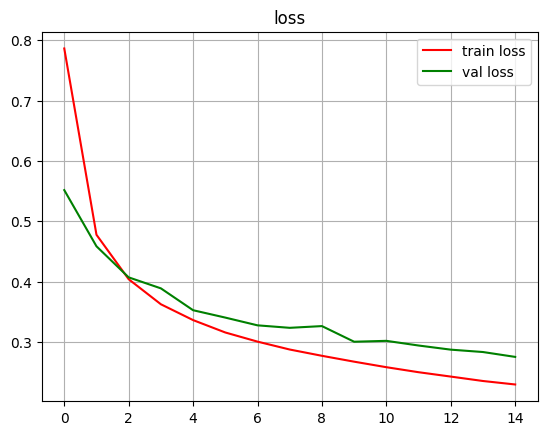

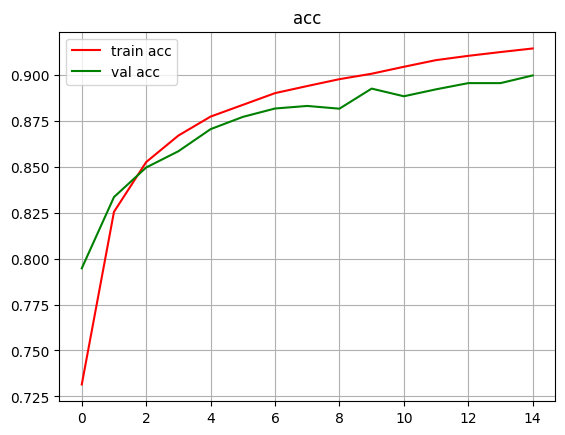

In [41]:
# Train the model
fit(model_6, dataloader, epochs=n_epochs)

In [42]:
# Save the model
torch.save(model_6.state_dict(), 'content/model_6.pth')

The model improves compared to the baseline Model 1, with an acceptable number of parameters to train (172,746). This model is chosen to proceed further.

#### Model 6 with Dropout

Dropout layers are applied to improve model 6.

In [43]:
# Model 6 creation with Dropout

class CNN_model_6_do(torch.nn.Module):
  def __init__(self, n_channels=1, n_outputs=10):
    super().__init__()

    conv_kernel_size=(5, 5)
    conv_stride_size=(1, 1)
    conv_padding_size='same'

    pool_kernel_size=(2, 2)
    pool_stride_size=(2, 2)

    self.conv1 = conv_block(n_channels, 16,
                            conv_kernel_size,
                            conv_padding_size=conv_padding_size,
                            conv_stride=conv_stride_size,
                            pool_kernel_size=pool_kernel_size,
                            pool_stride=pool_stride_size,
                            pool_padding_size=1)
    self.conv1_out = None
    self.conv2 = conv_block(16, 32,
                        conv_kernel_size,
                        conv_padding_size=conv_padding_size,
                        conv_stride=conv_stride_size,
                        pool_kernel_size=pool_kernel_size,
                        pool_stride=pool_stride_size,
                        pool_padding_size=1)
    self.conv2_out = None
    self.conv3 = conv_block(32, 64,
                    conv_kernel_size,
                    conv_padding_size=conv_padding_size,
                    conv_stride=conv_stride_size,
                    pool_kernel_size=pool_kernel_size,
                    pool_stride=pool_stride_size,
                    pool_padding_size=1)
    self.conv3_out = None
    self.conv4 = conv_block(64, 64,
                    conv_kernel_size,
                    conv_padding_size=conv_padding_size,
                    conv_stride=conv_stride_size,
                    pool_kernel_size=pool_kernel_size,
                    pool_stride=pool_stride_size,
                    pool_padding_size=1)
    self.drop = torch.nn.Dropout2d(p=0.7, inplace=False)
    self.conv4_out = None
    self.fc = torch.nn.Linear(576, n_outputs) # Verify the dimension of the output to calculate the size of the Fully Connected !!
    
    print('NNET created')

    print('NNET created')
    print('architecture:')
    print(self)

    i=0
    for layer in self.children():
        i=i+1
    print('Total number of CNN layers (conv+act+pooling) + fully connected added:', i)

    # Number of parameters to train
    pytorch_total_params = sum(p.numel() for p in self.parameters() if p.requires_grad)
    print('Total number of parameters to train: ', pytorch_total_params)

  def dim_validation(self, tam):
    # It is a "forward" function that prints the dimension of each step

    print("Dimensions validation")
    x = torch.randn(1, 1, int(tam), int(tam))
    print("Input size: ", x.shape)

    x = self.conv1(x)
    print("conv1 exit size: ", x.shape)
    x = self.conv2(x)
    print("conv2 exit size: ", x.shape)
    x = self.conv3(x)
    print("conv3 exit size: ", x.shape)
    x = self.conv4(x)
    print("conv4 exit size: ", x.shape)

    x = x.view(x.shape[0], -1)
    print("Vectorized image size: ", x.shape)
    x = self.fc(x)
    print("fc exit size (# classes): ", x.shape)

  def forward(self, x):
    self.conv1_out = self.conv1(x)
    self.conv2_out = self.conv2(self.conv1_out)
    self.conv3_out = self.conv3(self.conv2_out)
    self.conv4_out = self.drop(self.conv4(self.conv3_out))
    y = self.conv4_out.view(self.conv4_out.shape[0], -1)
    y = self.fc(y)
    
    return y

In [44]:
model_6_do = CNN_model_6_do()

NNET created
NNET created
architecture:
CNN_model_6_do(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=same)
    (1): Tanh()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=1, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=same)
    (1): Tanh()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=1, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=same)
    (1): Tanh()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=1, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=same)
    (1): Tanh()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=1, dilation=1, ceil_mode=False)
  )
  (drop): Dropout2d(p=0.7, inplace=False)
  (fc): Linear(in_features=576, out_features=10, bias=True)
)
T

In [45]:
model_6_do.cpu()
model_6_do.dim_validation(image.size()[1])

Dimensions validation
Input size:  torch.Size([1, 1, 28, 28])
conv1 exit size:  torch.Size([1, 16, 15, 15])
conv2 exit size:  torch.Size([1, 32, 8, 8])
conv3 exit size:  torch.Size([1, 64, 5, 5])
conv4 exit size:  torch.Size([1, 64, 3, 3])
Vectorized image size:  torch.Size([1, 576])
fc exit size (# classes):  torch.Size([1, 10])


val_loss 0.59742 val_acc 0.77777: 100%|██████████| 157/157 [00:01<00:00, 148.68it/s]


Epoch 1/15 loss 0.89955 val_loss 0.59742 acc 0.69065 val_acc 0.77777


val_loss 0.50202 val_acc 0.81270: 100%|██████████| 157/157 [00:01<00:00, 153.46it/s]


Epoch 2/15 loss 0.56171 val_loss 0.50202 acc 0.79907 val_acc 0.81270


val_loss 0.44792 val_acc 0.83400: 100%|██████████| 157/157 [00:01<00:00, 151.34it/s]


Epoch 3/15 loss 0.48290 val_loss 0.44792 acc 0.82738 val_acc 0.83400


val_loss 0.41205 val_acc 0.84823: 100%|██████████| 157/157 [00:01<00:00, 150.25it/s]


Epoch 4/15 loss 0.43611 val_loss 0.41205 acc 0.84438 val_acc 0.84823


val_loss 0.38622 val_acc 0.85908: 100%|██████████| 157/157 [00:01<00:00, 129.80it/s]


Epoch 5/15 loss 0.40309 val_loss 0.38622 acc 0.85599 val_acc 0.85908


val_loss 0.36504 val_acc 0.86694: 100%|██████████| 157/157 [00:01<00:00, 149.47it/s]


Epoch 6/15 loss 0.37865 val_loss 0.36504 acc 0.86444 val_acc 0.86694


val_loss 0.37610 val_acc 0.86117: 100%|██████████| 157/157 [00:01<00:00, 148.87it/s]


Epoch 7/15 loss 0.35921 val_loss 0.37610 acc 0.87270 val_acc 0.86117


val_loss 0.33789 val_acc 0.87490: 100%|██████████| 157/157 [00:01<00:00, 138.39it/s]


Epoch 8/15 loss 0.34372 val_loss 0.33789 acc 0.87655 val_acc 0.87490


val_loss 0.32932 val_acc 0.88027: 100%|██████████| 157/157 [00:01<00:00, 147.23it/s]


Epoch 9/15 loss 0.33122 val_loss 0.32932 acc 0.88180 val_acc 0.88027


val_loss 0.32233 val_acc 0.88167: 100%|██████████| 157/157 [00:01<00:00, 144.57it/s]


Epoch 10/15 loss 0.32243 val_loss 0.32233 acc 0.88498 val_acc 0.88167


val_loss 0.31863 val_acc 0.88396: 100%|██████████| 157/157 [00:01<00:00, 138.53it/s]


Epoch 11/15 loss 0.31228 val_loss 0.31863 acc 0.88746 val_acc 0.88396


val_loss 0.30740 val_acc 0.88923: 100%|██████████| 157/157 [00:01<00:00, 132.41it/s]


Epoch 12/15 loss 0.30317 val_loss 0.30740 acc 0.89154 val_acc 0.88923


val_loss 0.30564 val_acc 0.89003: 100%|██████████| 157/157 [00:01<00:00, 143.08it/s]


Epoch 13/15 loss 0.29723 val_loss 0.30564 acc 0.89284 val_acc 0.89003


val_loss 0.29385 val_acc 0.89202: 100%|██████████| 157/157 [00:01<00:00, 141.19it/s]


Epoch 14/15 loss 0.29082 val_loss 0.29385 acc 0.89529 val_acc 0.89202


val_loss 0.29003 val_acc 0.89242: 100%|██████████| 157/157 [00:01<00:00, 136.90it/s]


Epoch 15/15 loss 0.28196 val_loss 0.29003 acc 0.89955 val_acc 0.89242


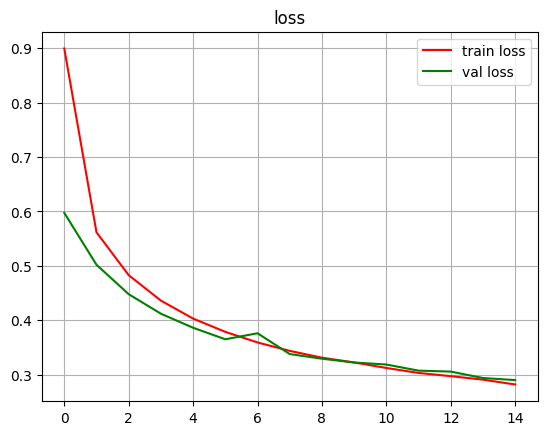

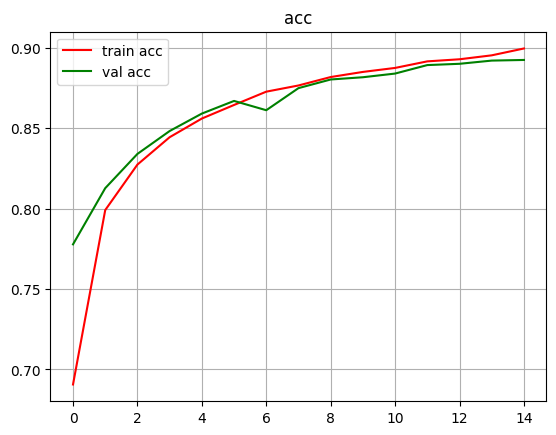

In [46]:
# Train the model
fit(model_6_do, dataloader, epochs=n_epochs)

In [47]:
# Save the model
torch.save(model_6_do.state_dict(), 'content/model_6_do.pth')

The application of a Dropout layer has a negligible effect on the validation performance (approximate values: val_acc 0.899 vs val_acc 0.892 with Dropout). It's interesting to note that for training, the difference between the model with Dropout and the model without Dropout is much more significant (approximate values: acc 0.91 vs acc 0.89 with Dropout). This is likely because there is some overfitting that Dropout helps alleviate.

This model will be used to proceed with the work.

## Part 2

In this section, transfer learning will be performed to process images from the MNIST dataset (containing digits) to identify numbers greater or less than 4,5. For training, only 20,000 samples from the training set will be used, and validation will be conducted using the test set. The class distribution will be balanced by reducing the training dataset.

Two different transfer learning strategies will be analyzed, suitable for the described scenario.

### Loading and preprocessing of the MNIST digits dataset.

In [48]:
# Download train data from open datasets.
train_data_mnist = datasets.MNIST(root='data', train=True, download=True, transform=ToTensor())

# Download test data from open datasets.
test_data_mnist = datasets.MNIST(root='data', train=False, download=True, transform=ToTensor())

In [49]:
from torchvision import transforms

In [50]:
# Number of samples
sample_size = 20000

# Total number of data in train
total_samples = len(train_data_mnist)

# Randomly select an amount of "sample_size" indices
selected_indices = np.random.choice(total_samples, size=sample_size, replace=False)

# Creation of the new reduced training dataset.
train_data_mnist_reduced = datasets.MNIST(root='data', train=True, download=True, transform=transforms.ToTensor())
train_data_mnist_reduced.data = train_data_mnist.data[selected_indices]
train_data_mnist_reduced.targets = train_data_mnist.targets[selected_indices]


In [51]:
# Adjusting labels to distinguish between numbers greater than or less than 4.5.
# The targets are set to 1 for numbers greater than 4.5 and to 0 for numbers less than 4.5.

train_data_mnist_reduced.targets = torch.where(train_data_mnist_reduced.targets > 4.5, torch.tensor(1), torch.tensor(0))
test_data_mnist.targets = torch.where(test_data_mnist.targets > 4.5, torch.tensor(1), torch.tensor(0))
train_data_mnist_reduced.targets, test_data_mnist.targets

(tensor([1, 0, 0,  ..., 0, 0, 0]), tensor([1, 0, 0,  ..., 0, 1, 1]))

The class distributions are verified to be balanced in the training set after randomly sampling 20,000 samples.

In [52]:
np.bincount(train_data_mnist_reduced.targets), np.bincount(test_data_mnist.targets)

(array([10267,  9733]), array([5139, 4861]))

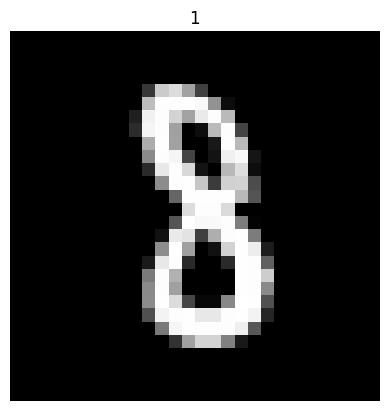

In [53]:
# Test image extraction
image_mnist, label = train_data_mnist_reduced[0]
figure.add_subplot(rows, cols, i)
plt.title(label)
plt.axis('off')
plt.imshow(image_mnist.squeeze(), cmap='gray')

In [54]:
# Dataloader creation
dataloader_MNIST_reduced = {
    'train': torch.utils.data.DataLoader(train_data_mnist_reduced, batch_size=64, shuffle=True, pin_memory=True),
    'test': torch.utils.data.DataLoader(test_data_mnist, batch_size=64, shuffle=False, pin_memory=True)
}

### Transfer Learning Strategies to Employ
Since the two datasets are different, it is decided to employ "Feature extraction from shallower layers" and "Fine-tuning (from pretrained models)" as the two strategies. Since the sample size has been reduced, it is expected that "Feature extraction from shallower layers" will perform better, as it is the preferred option for a small dataset.

#### Feature extraction from shallower layers

We analyze the architecture of the chosen model_6_do network. We are going to retrieve the first two layers (conv1 and conv2). The parameters will be frozen to prevent gradients from being calculated during training.

In [55]:
# Model loading
model_6_do = CNN_model_6_do()
model_6_do.load_state_dict(torch.load('content/model_6_do.pth'))

NNET created
NNET created
architecture:
CNN_model_6_do(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=same)
    (1): Tanh()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=1, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=same)
    (1): Tanh()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=1, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=same)
    (1): Tanh()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=1, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=same)
    (1): Tanh()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=1, dilation=1, ceil_mode=False)
  )
  (drop): Dropout2d(p=0.7, inplace=False)
  (fc): Linear(in_features=576, out_features=10, bias=True)
)
T

<All keys matched successfully>

In [56]:
model_6_do.parameters

<bound method Module.parameters of CNN_model_6_do(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=same)
    (1): Tanh()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=1, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=same)
    (1): Tanh()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=1, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=same)
    (1): Tanh()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=1, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=same)
    (1): Tanh()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=1, dilation=1, ceil_mode=False)
  )
  (drop): Dropout2d(p=0.7, inplace=False)
  (fc): Linear(in_features=576, out_features=10, bias=True)
)>

The first two layers of the model are selected.

In [57]:
source_model = nn.ModuleList(model_6_do.children())[:-4]
source_model

ModuleList(
  (0): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=same)
    (1): Tanh()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=1, dilation=1, ceil_mode=False)
  )
  (1): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=same)
    (1): Tanh()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=1, dilation=1, ceil_mode=False)
  )
)

The new class ShallowFEModel is created, and the gradient freeze of the source_model is performed within the constructor.

In [58]:
class ShallowFEModel(nn.Module):
  def __init__(self, source_model, n_channels=1, n_outputs=2):
    super().__init__()

    # Freezing of gradients for the source_model.
    for param in source_model.parameters():
        param.requires_grad = False
    self.fixed_layer = nn.Sequential(*source_model)
    self.fixed_layer_out = None

    self.fc = torch.nn.Linear(2048, n_outputs) # Verify the dimension of the output to calculate the size of the Fully Connected !!
    # self.sm = torch.nn.Softmax(dim=1)
    print('NNET created')

    print('NNET created')
    print('architecture:')
    print(self)

    i=0
    for layer in self.children():
        i=i+1
    print('Total number of CNN layers (conv+act+pooling) + fully connected added:', i)

    # Number of parameters to train
    pytorch_total_params = sum(p.numel() for p in self.parameters() if p.requires_grad)
    print('Total number of parameters to train: ', pytorch_total_params)

  def dim_validation(self, tam):
    # It is a "forward" function that prints the dimension of each step

    print("Dimensions validation")
    x = torch.randn(1, 1, int(tam), int(tam))
    print("Input size: ", x.shape)

    x = self.fixed_layer(x)
    print("fixed_layer exit size: ", x.shape)

    x = x.view(x.shape[0], -1)
    print("Vectorized image size: ", x.shape)
    x = self.fc(x)
    print("fc exit size (# classes): ", x.shape)

  def forward(self, x):
    self.fixed_layer_out = self.fixed_layer(x)
    y = self.fixed_layer_out.view(self.fixed_layer_out.shape[0], -1)
    y = self.fc(y)
    
    return y

In [59]:
model_6_do_feat_ex = ShallowFEModel(source_model)

NNET created
NNET created
architecture:
ShallowFEModel(
  (fixed_layer): Sequential(
    (0): Sequential(
      (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=same)
      (1): Tanh()
      (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=1, dilation=1, ceil_mode=False)
    )
    (1): Sequential(
      (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=same)
      (1): Tanh()
      (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=1, dilation=1, ceil_mode=False)
    )
  )
  (fc): Linear(in_features=2048, out_features=2, bias=True)
)
Total number of CNN layers (conv+act+pooling) + fully connected added: 2
Total number of parameters to train:  4098


In [60]:
model_6_do_feat_ex.cpu()
model_6_do_feat_ex.dim_validation(image_mnist.size()[1])

Dimensions validation
Input size:  torch.Size([1, 1, 28, 28])
fixed_layer exit size:  torch.Size([1, 32, 8, 8])
Vectorized image size:  torch.Size([1, 2048])
fc exit size (# classes):  torch.Size([1, 2])


val_loss 0.38952 val_acc 0.84713: 100%|██████████| 157/157 [00:00<00:00, 160.70it/s]


Epoch 1/15 loss 0.48664 val_loss 0.38952 acc 0.78559 val_acc 0.84713


val_loss 0.33080 val_acc 0.87082: 100%|██████████| 157/157 [00:00<00:00, 159.47it/s]


Epoch 2/15 loss 0.35942 val_loss 0.33080 acc 0.86227 val_acc 0.87082


val_loss 0.29527 val_acc 0.88873: 100%|██████████| 157/157 [00:00<00:00, 161.11it/s]


Epoch 3/15 loss 0.30898 val_loss 0.29527 acc 0.88718 val_acc 0.88873


val_loss 0.26256 val_acc 0.90993: 100%|██████████| 157/157 [00:00<00:00, 161.36it/s]


Epoch 4/15 loss 0.27784 val_loss 0.26256 acc 0.90071 val_acc 0.90993


val_loss 0.24587 val_acc 0.91342: 100%|██████████| 157/157 [00:01<00:00, 147.85it/s]


Epoch 5/15 loss 0.25555 val_loss 0.24587 acc 0.91039 val_acc 0.91342


val_loss 0.23072 val_acc 0.92118: 100%|██████████| 157/157 [00:01<00:00, 156.22it/s]


Epoch 6/15 loss 0.23824 val_loss 0.23072 acc 0.91703 val_acc 0.92118


val_loss 0.22000 val_acc 0.92586: 100%|██████████| 157/157 [00:01<00:00, 144.81it/s]


Epoch 7/15 loss 0.22464 val_loss 0.22000 acc 0.92267 val_acc 0.92586


val_loss 0.21062 val_acc 0.92705: 100%|██████████| 157/157 [00:01<00:00, 138.42it/s]


Epoch 8/15 loss 0.21396 val_loss 0.21062 acc 0.92727 val_acc 0.92705


val_loss 0.20360 val_acc 0.93113: 100%|██████████| 157/157 [00:01<00:00, 134.89it/s]


Epoch 9/15 loss 0.20514 val_loss 0.20360 acc 0.92961 val_acc 0.93113


val_loss 0.19596 val_acc 0.93392: 100%|██████████| 157/157 [00:01<00:00, 133.16it/s]


Epoch 10/15 loss 0.19685 val_loss 0.19596 acc 0.93341 val_acc 0.93392


val_loss 0.19192 val_acc 0.93422: 100%|██████████| 157/157 [00:01<00:00, 115.42it/s]


Epoch 11/15 loss 0.18967 val_loss 0.19192 acc 0.93655 val_acc 0.93422


val_loss 0.18548 val_acc 0.93611: 100%|██████████| 157/157 [00:01<00:00, 139.40it/s]


Epoch 12/15 loss 0.18387 val_loss 0.18548 acc 0.93825 val_acc 0.93611


val_loss 0.18048 val_acc 0.93840: 100%|██████████| 157/157 [00:01<00:00, 130.93it/s]


Epoch 13/15 loss 0.17864 val_loss 0.18048 acc 0.94074 val_acc 0.93840


val_loss 0.17805 val_acc 0.93730: 100%|██████████| 157/157 [00:00<00:00, 159.73it/s]


Epoch 14/15 loss 0.17376 val_loss 0.17805 acc 0.94169 val_acc 0.93730


val_loss 0.17218 val_acc 0.94039: 100%|██████████| 157/157 [00:01<00:00, 155.09it/s]


Epoch 15/15 loss 0.16942 val_loss 0.17218 acc 0.94354 val_acc 0.94039


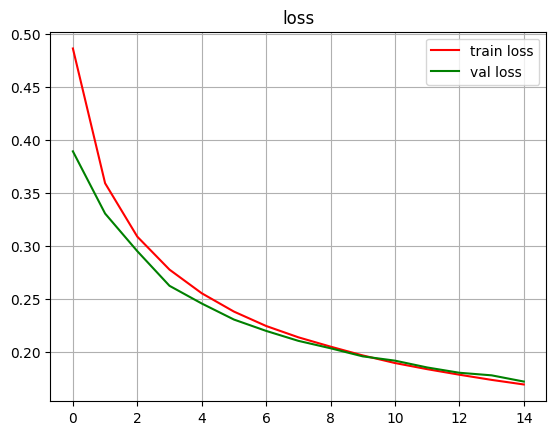

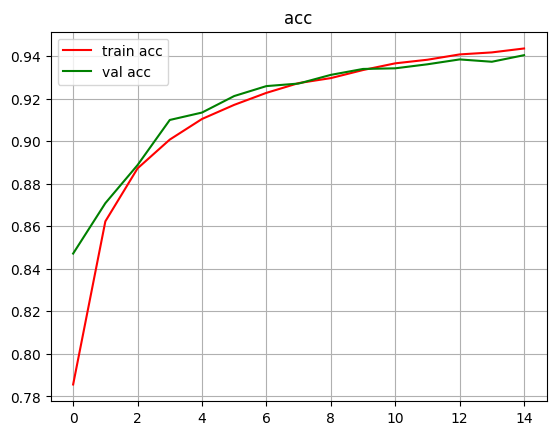

In [61]:
# Train the model
fit(model_6_do_feat_ex, dataloader_MNIST_reduced, epochs=n_epochs)

In [62]:
# The parameters are checked to confirm that they have not been trained.

model_6_do_parameters = list(model_6_do.conv1.parameters())
model_6_do_parameters.extend(list(model_6_do.conv2.parameters()))
model_6_do_feat_ex_parameters = list(model_6_do_feat_ex.fixed_layer.parameters())

for i in range(len(model_6_do_parameters)):
    print(torch.eq(model_6_do_parameters[i], model_6_do_feat_ex_parameters[i]))

tensor([[[[True, True, True, True, True],
          [True, True, True, True, True],
          [True, True, True, True, True],
          [True, True, True, True, True],
          [True, True, True, True, True]]],


        [[[True, True, True, True, True],
          [True, True, True, True, True],
          [True, True, True, True, True],
          [True, True, True, True, True],
          [True, True, True, True, True]]],


        [[[True, True, True, True, True],
          [True, True, True, True, True],
          [True, True, True, True, True],
          [True, True, True, True, True],
          [True, True, True, True, True]]],


        [[[True, True, True, True, True],
          [True, True, True, True, True],
          [True, True, True, True, True],
          [True, True, True, True, True],
          [True, True, True, True, True]]],


        [[[True, True, True, True, True],
          [True, True, True, True, True],
          [True, True, True, True, True],
          [True, T

Indeed, obtaining all values as "True" confirms that the fixed_layer of the model model_6_do_feat_ex shares the same parameters as the conv1 and conv2 layers of model_6_do.

#### Fine tunning (from pretrained models)

To execute this strategy, the selected model will be pre-trained with few epochs to prevent it from learning too much from the original dataset (Fashion MNIST).
Once we have this pre-trained model, a new class will be created that takes it as a parameter in its constructor. The necessary layers will be added accordingly.

In [63]:
# Model creation
model_6_do_pre_trained = CNN_model_6_do()

NNET created
NNET created
architecture:
CNN_model_6_do(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=same)
    (1): Tanh()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=1, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=same)
    (1): Tanh()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=1, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=same)
    (1): Tanh()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=1, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=same)
    (1): Tanh()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=1, dilation=1, ceil_mode=False)
  )
  (drop): Dropout2d(p=0.7, inplace=False)
  (fc): Linear(in_features=576, out_features=10, bias=True)
)
T

In [64]:
model_6_do_pre_trained.cpu()
model_6_do_pre_trained.dim_validation(image_mnist.size()[1])

Dimensions validation
Input size:  torch.Size([1, 1, 28, 28])
conv1 exit size:  torch.Size([1, 16, 15, 15])
conv2 exit size:  torch.Size([1, 32, 8, 8])
conv3 exit size:  torch.Size([1, 64, 5, 5])
conv4 exit size:  torch.Size([1, 64, 3, 3])
Vectorized image size:  torch.Size([1, 576])
fc exit size (# classes):  torch.Size([1, 10])


val_loss 0.61978 val_acc 0.76095: 100%|██████████| 157/157 [00:01<00:00, 152.29it/s]


Epoch 1/2 loss 0.93345 val_loss 0.61978 acc 0.67128 val_acc 0.76095


val_loss 0.51030 val_acc 0.80792: 100%|██████████| 157/157 [00:01<00:00, 153.82it/s]


Epoch 2/2 loss 0.57160 val_loss 0.51030 acc 0.79694 val_acc 0.80792


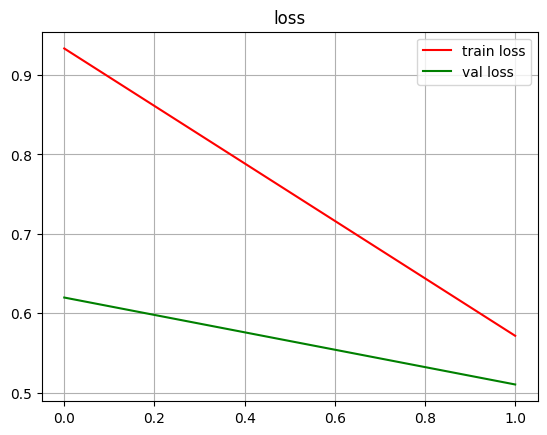

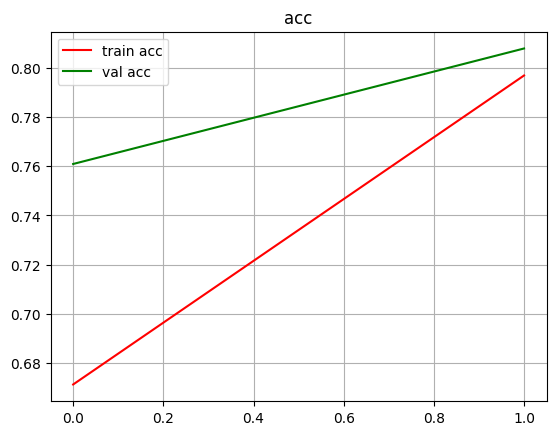

In [65]:
# Train the model
fit(model_6_do_pre_trained, dataloader, epochs=2)

In [66]:
# Save the model
torch.save(model_6_do_pre_trained.state_dict(), 'content/model_6_do_pre_trained.pth')

Only 2 epochs were executed for training to keep the pre-trained model with a low accuracy.

In [67]:
class FineTunningModel(nn.Module):
  def __init__(self, pre_trained_model, n_channels=1, n_outputs=2):
    super().__init__()

    self.pre_trained_model = nn.Sequential(*pre_trained_model)

    self.pre_trained_model_out = None

    self.drop = torch.nn.Dropout2d(p=0.7, inplace=False)

    self.fc = torch.nn.Linear(576, n_outputs) # Verify the dimension of the output to calculate the size of the Fully Connected !!
    # self.sm = torch.nn.Softmax(dim=1)    print('NNET created')

    print('NNET created')
    print('architecture:')
    print(self)

    i=0
    for layer in self.children():
        i=i+1
    print('Total number of CNN layers (conv+act+pooling) + fully connected added:', i)

    # Number of parameters to train
    pytorch_total_params = sum(p.numel() for p in self.parameters() if p.requires_grad)
    print('Total number of parameters to train: ', pytorch_total_params)

  def dim_validation(self, tam):
    # It is a "forward" function that prints the dimension of each step

    print("Dimensions validation")
    x = torch.randn(1, 1, int(tam), int(tam))
    print("Input size: ", x.shape)

    x = self.pre_trained_model(x)
    print("pre_trained_model exit size: ", x.shape)

    x = x.view(x.shape[0], -1)
    print("Vectorized image size: ", x.shape)
    x = self.fc(x)
    print("fc exit size (# classes): ", x.shape)

  def forward(self, x):
    self.pre_trained_model_out = self.drop(self.pre_trained_model(x))
    y = self.pre_trained_model_out.view(self.pre_trained_model_out.shape[0], -1)
    y = self.fc(y)
    
    return y

In [69]:
# Model loading
model_6_do_pre_trained = CNN_model_6_do()
model_6_do_pre_trained.load_state_dict(torch.load('content/model_6_do_pre_trained.pth'))

NNET created
NNET created
architecture:
CNN_model_6_do(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=same)
    (1): Tanh()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=1, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=same)
    (1): Tanh()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=1, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=same)
    (1): Tanh()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=1, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=same)
    (1): Tanh()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=1, dilation=1, ceil_mode=False)
  )
  (drop): Dropout2d(p=0.7, inplace=False)
  (fc): Linear(in_features=576, out_features=10, bias=True)
)
T

<All keys matched successfully>

In [70]:
pre_trained_model = nn.ModuleList(model_6_do_pre_trained.children())[:-2]
pre_trained_model

ModuleList(
  (0): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=same)
    (1): Tanh()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=1, dilation=1, ceil_mode=False)
  )
  (1): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=same)
    (1): Tanh()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=1, dilation=1, ceil_mode=False)
  )
  (2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=same)
    (1): Tanh()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=1, dilation=1, ceil_mode=False)
  )
  (3): Sequential(
    (0): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=same)
    (1): Tanh()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=1, dilation=1, ceil_mode=False)
  )
)

In [71]:
model_6_do_fine_t = FineTunningModel(pre_trained_model)

NNET created
architecture:
FineTunningModel(
  (pre_trained_model): Sequential(
    (0): Sequential(
      (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=same)
      (1): Tanh()
      (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=1, dilation=1, ceil_mode=False)
    )
    (1): Sequential(
      (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=same)
      (1): Tanh()
      (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=1, dilation=1, ceil_mode=False)
    )
    (2): Sequential(
      (0): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=same)
      (1): Tanh()
      (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=1, dilation=1, ceil_mode=False)
    )
    (3): Sequential(
      (0): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=same)
      (1): Tanh()
      (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=1, dilation=1, ceil_mode=False)
    )
  )
  (drop): Dropout2d(p=0.7, inplace=False)
  (fc): Lin

In [72]:
model_6_do_fine_t.cpu()
model_6_do_fine_t.dim_validation(image_mnist.size()[1])

Dimensions validation
Input size:  torch.Size([1, 1, 28, 28])
pre_trained_model exit size:  torch.Size([1, 64, 3, 3])
Vectorized image size:  torch.Size([1, 576])
fc exit size (# classes):  torch.Size([1, 2])


val_loss 0.25853 val_acc 0.90595: 100%|██████████| 157/157 [00:00<00:00, 160.87it/s]


Epoch 1/15 loss 0.41940 val_loss 0.25853 acc 0.81335 val_acc 0.90595


val_loss 0.16025 val_acc 0.94198: 100%|██████████| 157/157 [00:00<00:00, 160.01it/s]


Epoch 2/15 loss 0.21232 val_loss 0.16025 acc 0.92367 val_acc 0.94198


val_loss 0.11858 val_acc 0.95790: 100%|██████████| 157/157 [00:01<00:00, 152.62it/s]


Epoch 3/15 loss 0.14520 val_loss 0.11858 acc 0.94988 val_acc 0.95790


val_loss 0.11183 val_acc 0.95900: 100%|██████████| 157/157 [00:01<00:00, 156.75it/s]


Epoch 4/15 loss 0.11346 val_loss 0.11183 acc 0.96256 val_acc 0.95900


val_loss 0.08546 val_acc 0.96885: 100%|██████████| 157/157 [00:01<00:00, 153.97it/s]


Epoch 5/15 loss 0.09384 val_loss 0.08546 acc 0.96750 val_acc 0.96885


val_loss 0.07669 val_acc 0.97203: 100%|██████████| 157/157 [00:01<00:00, 155.84it/s]


Epoch 6/15 loss 0.08058 val_loss 0.07669 acc 0.97219 val_acc 0.97203


val_loss 0.07136 val_acc 0.97472: 100%|██████████| 157/157 [00:01<00:00, 152.52it/s]


Epoch 7/15 loss 0.07274 val_loss 0.07136 acc 0.97449 val_acc 0.97472


val_loss 0.06541 val_acc 0.97761: 100%|██████████| 157/157 [00:01<00:00, 147.86it/s]


Epoch 8/15 loss 0.06466 val_loss 0.06541 acc 0.97863 val_acc 0.97761


val_loss 0.06599 val_acc 0.97701: 100%|██████████| 157/157 [00:01<00:00, 145.40it/s]


Epoch 9/15 loss 0.05750 val_loss 0.06599 acc 0.98013 val_acc 0.97701


val_loss 0.06256 val_acc 0.97791: 100%|██████████| 157/157 [00:01<00:00, 153.05it/s]


Epoch 10/15 loss 0.05094 val_loss 0.06256 acc 0.98258 val_acc 0.97791


val_loss 0.05507 val_acc 0.98020: 100%|██████████| 157/157 [00:01<00:00, 140.60it/s]


Epoch 11/15 loss 0.04669 val_loss 0.05507 acc 0.98368 val_acc 0.98020


val_loss 0.05352 val_acc 0.98209: 100%|██████████| 157/157 [00:01<00:00, 146.34it/s]


Epoch 12/15 loss 0.04204 val_loss 0.05352 acc 0.98582 val_acc 0.98209


val_loss 0.05377 val_acc 0.98209: 100%|██████████| 157/157 [00:01<00:00, 145.27it/s]


Epoch 13/15 loss 0.03914 val_loss 0.05377 acc 0.98602 val_acc 0.98209


val_loss 0.05156 val_acc 0.98179: 100%|██████████| 157/157 [00:01<00:00, 150.60it/s]


Epoch 14/15 loss 0.03542 val_loss 0.05156 acc 0.98897 val_acc 0.98179


val_loss 0.04920 val_acc 0.98328: 100%|██████████| 157/157 [00:01<00:00, 140.96it/s]


Epoch 15/15 loss 0.03316 val_loss 0.04920 acc 0.98897 val_acc 0.98328


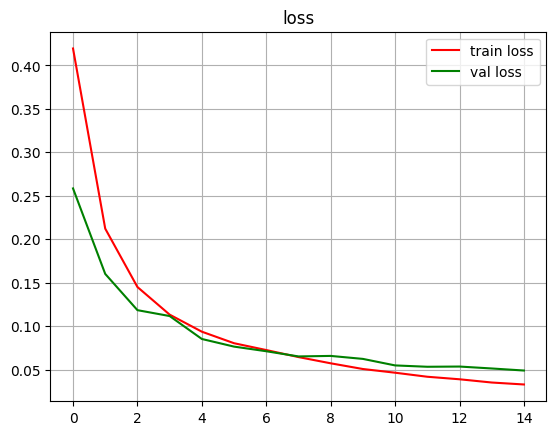

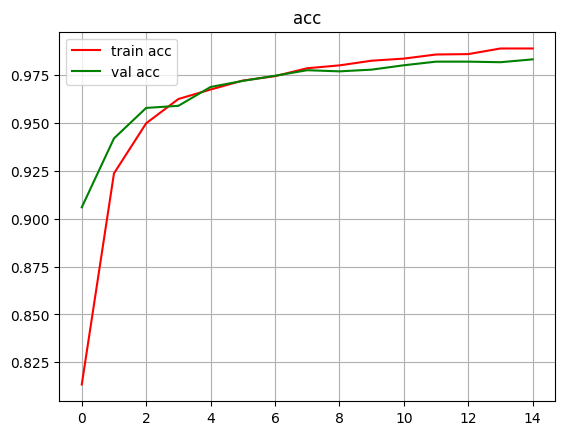

In [73]:
# Train the model
fit(model_6_do_fine_t, dataloader_MNIST_reduced, epochs=n_epochs)

### Conclusions

We can observe that Fine-Tuning achieved better performance with a validation accuracy of 0.98 compared to Feature Extractor with a validation accuracy of 0.94. While both strategies yielded commendable results, the disparity in performance between them is notable.

As mentioned at the beginning of this section, it was expected that the Feature Extractor would perform better, given that the training dataset had been reduced. However, it seems that this amount of data (20,000) was sufficient to perform correct training using the Fine-Tuning strategy.

It is important to note that the architecture of the Fine-Tuning model is more complex and has many more parameters to train. The architecture of the Feature Extractor model has half the number of convolutional layers and performs very well in comparison, with many fewer parameters to train.


- FeatureExtractor model architecture

```
NNET created
architecture:
ShallowFEModel(
  (fixed_layer): Sequential(
    (0): Sequential(
      (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=same)
      (1): Tanh()
      (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=1, dilation=1, ceil_mode=False)
    )
    (1): Sequential(
      (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=same)
      (1): Tanh()
      (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=1, dilation=1, ceil_mode=False)
    )
  )
  (fc): Linear(in_features=2048, out_features=2, bias=True)
)
Total number of CNN layers (conv+act+pooling) + fully connected added:  2
Total number of parameters to train:  4098
```
<br>

- FineTunning model architecture

```
NNET created
architecture:
CNN_model_6_do(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=same)
    (1): Tanh()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=1, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=same)
    (1): Tanh()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=1, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=same)
    (1): Tanh()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=1, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=same)
    (1): Tanh()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=1, dilation=1, ceil_mode=False)
  )
  (drop): Dropout2d(p=0.7, inplace=False)
  (fc): Linear(in_features=576, out_features=10, bias=True)
)
Total number of CNN layers (conv+act+pooling) + fully connected added:  6
Total number of parameters to train:  172746
<All keys matched successfully>
```


The difference in parameters to train is substantially different, with 172,746 for the Fine-Tuning model versus 4,098 for the Feature Extractor model.

For this reason, the Feature Extractor model is more suitable. It would be interesting to explore a more complex architecture for the Feature Extractor and conduct further testing. Due to time constraints, this task is not pursued at the moment.